### Dataset Preparation

In [1]:
import numpy as nnp
import os
from pathlib import Path
from keras.preprocessing import image

Using TensorFlow backend.


In [27]:
p = Path("images/")

dirs = p.glob("*")

labels_dict = {"cat":0,"dog":1,"horse":2,"human":3}

image_data = []
labels = []

for folder_name in dirs:
    label = str(folder_name).split("\\")[-1][:-1]
    
    for img_path in folder_name.glob("*.jpg"):
        img = image.load_img(img_path,target_size=(100,100))
        img_array = image.img_to_array(img)
        
        image_data.append(img_array)
        labels.append(labels_dict[label])
    

In [28]:
print(len(image_data))
print(len(labels))

808
808


In [29]:
# Converting this into numpy array
import numpy as np
image_data = np.array(image_data,dtype='float32')/255.0
labels = np.array(labels)

print(image_data.shape,labels.shape)

(808, 100, 100, 3) (808,)


### Randomly shuffle the data

In [30]:
import random

combined = list(zip(image_data,labels))
random.shuffle(combined)

# Unzip
image_data[:],labels[:] = zip(*combined)

### Visualize this Data

In [31]:
import matplotlib.pyplot as plt
def drawImg(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show() 

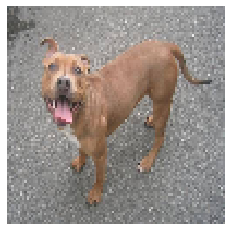

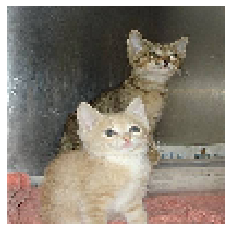

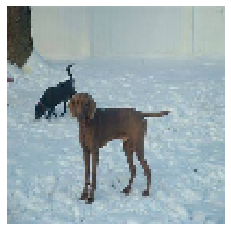

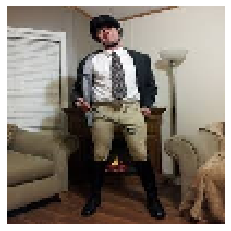

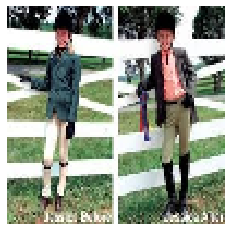

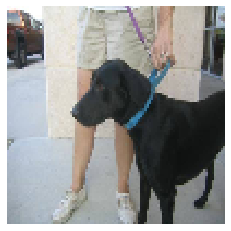

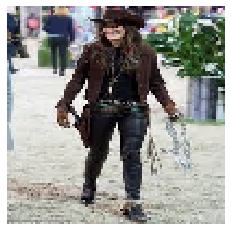

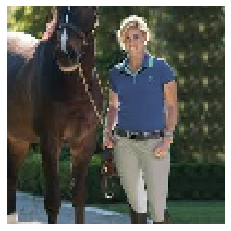

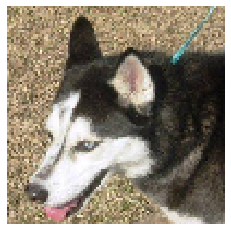

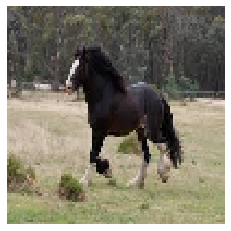

In [32]:
for i in range(10):
    drawImg(image_data[i])

# SVM Classifier

In [33]:
class SVM:
    
    def __init__(self,C=1.0):
        self.C = C
        self.W = 0
        self.b = 0
        
    def hingeLoss(self,W,b,X,Y):
        loss = 0.0
        
        loss += 0.5 * np.dot(W,W.T)
        
        m = X.shape[0]
        for i in range(m):
            ti = Y[i] * (np.dot(W,X[i].T)+b) # ti is sacalar
            loss += self.C * max(0,(1-ti))
        
        return loss[0][0] # loss is a 2-d matrix of form- [[400.0]] --> 400.0
    
    def fit(self,X,Y,batch_size=100,learning_rate=0.001,maxItr=300):
        
        no_of_features = X.shape[1] # 2
        no_of_samples = X.shape[0] # 400
        
        n = learning_rate
        c = self.C
        
        # Init the model parameters
        W = np.zeros((1,no_of_features)) # [w1,w2] - [0,0]
        bias = 0
        
        # Training from here...
        # Weight and bias update rule
        losses = []
        
        for i in range(maxItr):
            #Training Loop
            l = self.hingeLoss(W,bias,X,Y)
            losses.append(l)
            ids = np.arange(no_of_samples) # np arr from [0,1,2..,399]
            np.random.shuffle(ids) # randomly shuffled above ids arr. For batch grad desc with random shuffling
            
            # Batch Gradient Descent(in Paper) with Random Shuffling
            for batch_start in range(0,no_of_samples,batch_size):  # take jump of batch_size every time
                # Assume 0 gradient for batch - (for every batch, grad will be 0)
                gradw = 0
                gradb = 0
                
                # Iterate over all examples in the mini-batch
                for j in range(batch_start,batch_start+batch_size): # if batch size = 10,
                                                # then j - 1st itr-[0-9], 2nd itr - [10-19], and so on. 
                    if j < no_of_samples: # prevent arr out of bound
                        
                        i = ids[j] # j is just indx, i is example no from random shuffled ids
                        ti = Y[i] * (np.dot(W,X[i].T)+bias)
                        
                        if ti > 1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += c*Y[i]*X[i]
                            gradb += c*Y[i]
                            
                # Gradient for the batch is ready! Update W,B
                W = W - n*W + n*gradw
                bias = bias + n*gradb
                
                
        self.W = W
        self.b = bias
        return W,bias,losses
    
    
    def plotHyperplane(self,X,Y,w1,w2,b):
        
        plt.figure(figsize=(12,12))
        
        x_1 = np.linspace(-2,4,10)
        x_2 = -(w1*x_1+b)/w2 # WT + B = 0
        
        x_p = -(w1*x_1+b+1)/w2 # WT + B = -1
        x_n = -(w1*x_1+b-1)/w2 # WT + B = +1
        
        plt.plot(x_1,x_2,label = "Hyperplane WX + B = 0")
        plt.plot(x_1,x_p,label = "+ve Hyperplane WX + B = -1")
        plt.plot(x_1,x_n,label = "-ve Hyperplane WX + B = +1")
        
        plt.scatter(X[:,0],X[:,1],c=Y)
        plt.show()
    

### Convert data for one-for-one Classification

In [35]:
m = image_data.shape[0]
image_data = image_data.reshape(m,-1)
print(image_data.shape)
print(labels.shape)

(808, 30000)
(808,)


In [39]:
classes = np.unique(labels)
print(classes)

no_of_classes = len(classes)
print(no_of_classes)

[0 1 2 3]
4


In [43]:
def classWiseData(x,y):
    data = {}
    
    for i in range(no_of_classes):
        data[i] = []
        
    for i in range(x.shape[0]):
        data[y[i]].append(x[i])
        
    # Converting list into numpy 
    for k in data.keys():
        data[k] = np.array(data[k])
        
    return data

In [44]:
data = classWiseData(image_data,labels)

In [45]:
print(data[0].shape)

(202, 30000)


In [46]:
def getDataPairForSVM(d1,d2):
    
    l1,l2 = d1.shape[0],d2.shape[0]
    
    samples = l1+l2
    features = d1.shape[1]
    
    data_pair = np.zeros((samples,features))
    data_labels = np.zeros((samples,))
    
    data_pair[:l1,:] = d1
    data_pair[l1:,:] = d2
    
    data_labels[:l1] = -1
    data_labels[l1:] = +1
    
    return data_pair,data_labels

### Training NC2 SVM's Part

In [47]:
 mySVM = SVM()

In [70]:
def trainSVMs(x,y):
    
    svm_clasifiers = {}
    
    for i in range(no_of_classes):
        svm_clasifiers[i] = {}
        for j in range(i+1,no_of_classes):
            xpair,ypair = getDataPairForSVM(data[i],data[j])
            wts,b,loss = mySVM.fit(xpair,ypair,learning_rate=0.000001,maxItr=1000)
            svm_clasifiers[i][j] = (wts,b)
            
            plt.plot(loss)
            plt.show()
            
    return svm_clasifiers

In [49]:
svm_classifiers = trainSVMs(image_data,labels)

In [50]:
# Parameters for Cat and Dog pair
cats_dogs = svm_classifiers[0][1]
print(cats_dogs[0].shape)
print(cats_dogs[1])

(1, 30000)
0.01100000000000018


In [51]:
print(svm_classifiers[0])

{1: (array([[-0.01151673,  0.18061024,  0.04819542, ..., -0.00322891,
         0.11641284,  0.08887   ]]), 0.01100000000000018), 2: (array([[0.1648944 , 0.29480283, 0.33105922, ..., 0.26778811, 0.32749772,
        0.04784393]]), -1.1759999999999988), 3: (array([[0.38221369, 0.40322995, 0.40675188, ..., 0.15170693, 0.3086092 ,
        0.31237897]]), -0.30200000000000027)}


### Prediction

In [53]:
def binaryPredict(x,w,b):
    z = np.dot(x,w.T) + b
    
    if z>=0:
        return 1
    else:
        return -1

In [54]:
def predict(x):
    
    count = np.zeros((no_of_classes,))
    
    for i in range(no_of_classes):
        for j in range(i+1,no_of_classes):
            w,b = svm_classifiers[i][j]
            # Take a majority prediction
            z = binaryPredict(x,w,b)
            
            if z==1:
                count[j] += 1
            else:
                count[i] += 1
                
    final_prediction = np.argmax(count)
    return final_prediction
    

In [56]:
print(predict(image_data[1]))
print(labels[1])

0
0


In [57]:
def accuracy(x,y):
    
    count = 0
    for i in range(x.shape[0]):
        prediction = predict(x[i])
        if prediction == y[i]:
            count += 1
            
    return count/x.shape[0]

In [58]:
acc = accuracy(image_data,labels)

In [59]:
print(acc)

0.3712871287128713


### Analyzing Loss

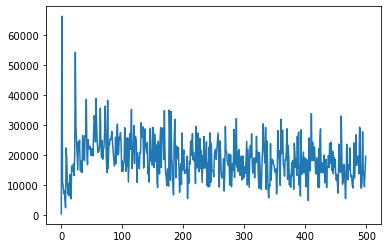

In [60]:
mySVM = SVM()
xp, yp = getDataPairForSVM(data[0],data[1])
w,b,losses = mySVM.fit(xp,yp,learning_rate=0.001,maxItr=500)
plt.plot(losses)
plt.show()

[404.0, 403.16582173367, 402.33164785067385, 401.4974797647275, 400.6633170052816, 399.82915913235377, 398.9950058718838, 398.16085797903673, 397.3267151984331, 396.49257721351125, 395.65844446971073, 394.824316434667, 393.99019377053384, 393.1560762824358, 392.32196322759995, 391.48785464691645, 390.6537519957745, 389.81965448742983, 388.98556119516854, 388.1514731243812, 387.31738976488776, 386.531172379692, 385.79623524820386, 385.0959916417053, 384.34708432284776, 383.6357262247215, 382.92233935569425, 382.2688868075587, 381.49644643104534, 380.79967628723324, 380.1833019640272, 379.4096107202308, 378.7544493216816, 378.050998476871, 377.3854948836491, 376.66201610475196, 375.97762652801634, 375.30377605947217, 374.6078873471314, 373.97669039240196, 373.27097642717035, 372.5847520741088, 371.8985272726097, 371.2297277732278, 370.5758792704434, 370.0849715059793, 369.25099652099254, 368.5670257577804, 367.8912024814897, 367.24230174168315, 366.62084540385814, 365.9450340122015, 365.

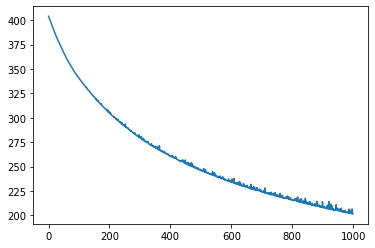

In [69]:
# Change learning rate and epochs

mySVM = SVM()
xp, yp = getDataPairForSVM(data[0],data[1])
w,b,losses = mySVM.fit(xp,yp,learning_rate=0.000001,maxItr=1000)
print(losses)
plt.plot(losses)
plt.show()

In [ ]:
## Using Prebuilt Model

In [73]:
from sklearn import svm

In [74]:
svm_classifier = svm.SVC(kernel='linear',C=1.0)

In [76]:
svm_classifier.fit(image_data,labels)
svm_classifier.score(image_data,labels)

0.6707920792079208

In [ ]:
## On Our Model

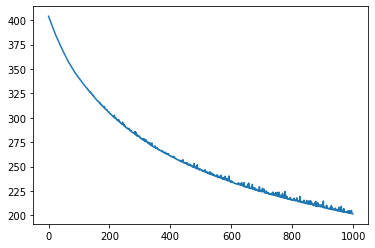

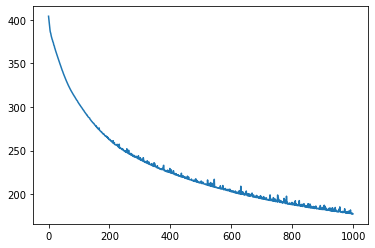

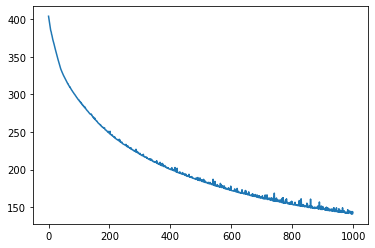

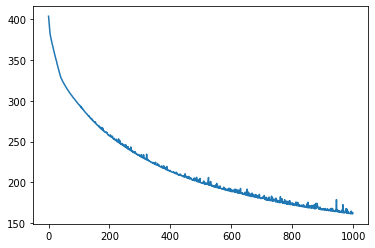

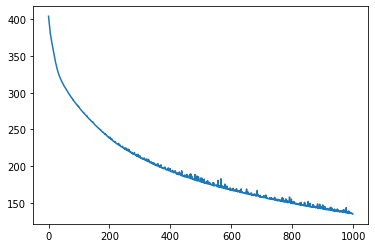

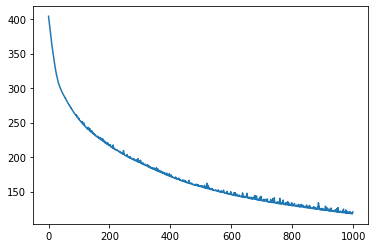

In [77]:
svm_classifiers = trainSVMs(image_data,labels)

In [78]:
acc = accuracy(image_data,labels)
print(acc)

0.625
